In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori, association_rules
pd.set_option('display.width', 500)
pd.set_option('display.expand_frame_repr', False)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/online-retail-ii/online_retail_II.xlsx


 Association rule learning is a rule-based machine learning method for discovering interesting relations between variables in datasets. The most of electronic marketplace are used this methods for be able to offer some items to their customers. 

 

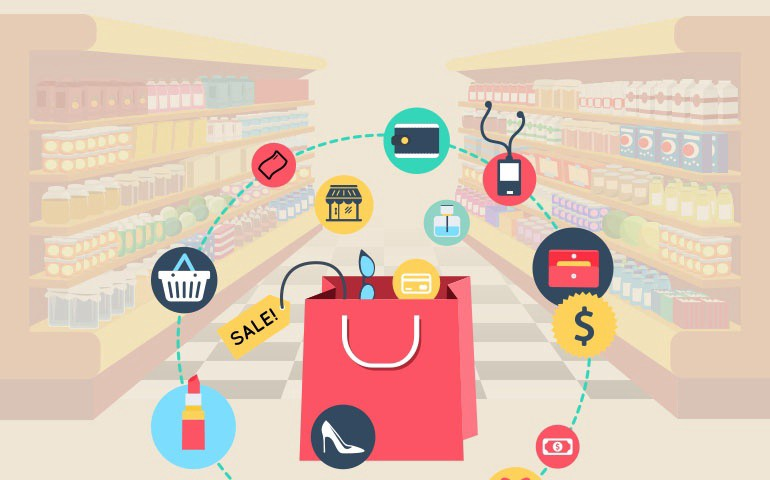

In this case, we use the apriori algoritm for extracting associations with targeted items. Let's explain with an example:
 
 This method has 3 metrics: 
 
*  Support(X,Y) = Freq(X,Y) /N
*  Confidence(X,Y) = Freq(X,Y) / Freq(X)
*  Lift = Support(X,Y) / (Support(X) * Support(Y))

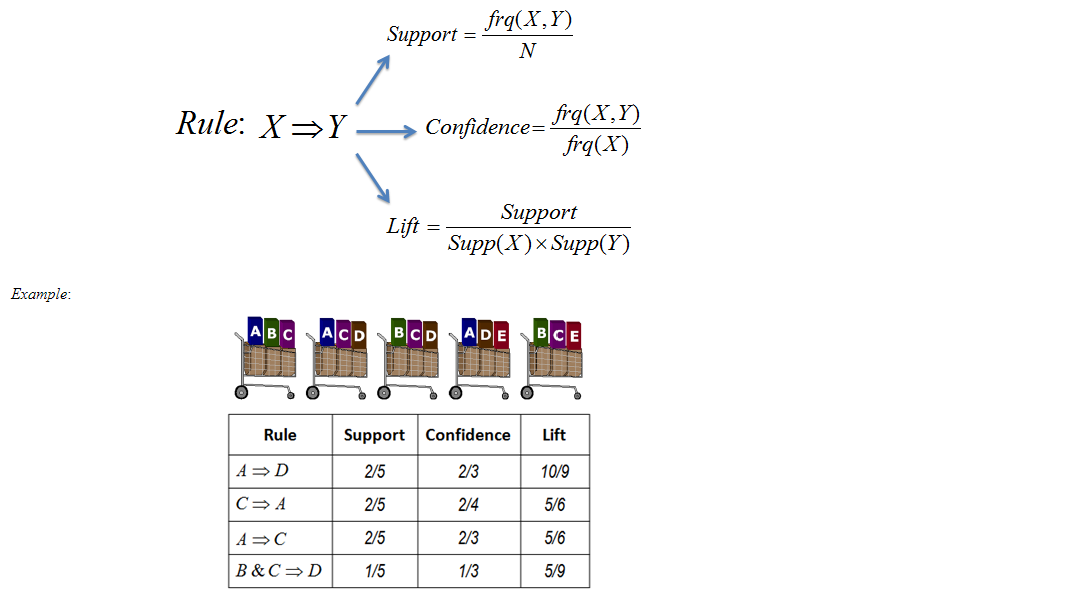

In this case, we will focus on Online Retail II datasets. This dataset include:

* Invoice: Invoice number. If this number starts with ‘C’, it means this transaction is cancelled.
* StockCode: Product code
* Description: Product Name
* Quantity: Product counts
* InvoiceDate: Transaction date
* Price: A single product price
* CustomerID: Unique customer number
* Country: Customer’s country name

In [2]:
df_= pd.read_excel('/kaggle/input/online-retail-ii/online_retail_II.xlsx',sheet_name='Year 2010-2011')

In [3]:
df = df_.copy()

**Preperation of Data**

In [4]:
def check_df(dataframe):
    print("############ Head ##############")
    print(dataframe.head())
    print("############ Shape ##############")
    print(dataframe.shape)
    print("############ N/A ##############")
    print(dataframe.isnull().sum())
    print("############ Types ##############")
    print(dataframe.dtypes)
    print("############ Quantile ##############")
    print(dataframe.describe().T)

check_df(df)

############ Head ##############
  Invoice StockCode                          Description  Quantity         InvoiceDate  Price  Customer ID         Country
0  536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6 2010-12-01 08:26:00   2.55      17850.0  United Kingdom
1  536365     71053                  WHITE METAL LANTERN         6 2010-12-01 08:26:00   3.39      17850.0  United Kingdom
2  536365    84406B       CREAM CUPID HEARTS COAT HANGER         8 2010-12-01 08:26:00   2.75      17850.0  United Kingdom
3  536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6 2010-12-01 08:26:00   3.39      17850.0  United Kingdom
4  536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6 2010-12-01 08:26:00   3.39      17850.0  United Kingdom
############ Shape ##############
(541910, 8)
############ N/A ##############
Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    1350

In [5]:
#  This function to determine the threshold values of the data.
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [6]:
# Replaces the determined outlier threshold values with outliers.
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [7]:
# In this function, we extract the values containing 'C' from the data.
# To calculate Total Price, the variables Quantity and Price must be greater than zero.
# We close the function by calling the Outlier and Threshold functions.
def retail_data_prep(dataframe):
    dataframe.dropna(inplace=True)
    dataframe = dataframe[~dataframe["Invoice"].astype(str).str.contains("C", na=False)]
    dataframe = dataframe[dataframe["Quantity"] > 0 ]
    dataframe = dataframe[dataframe["Price"] > 0]
    replace_with_thresholds(dataframe, "Quantity")
    replace_with_thresholds(dataframe, "Price")
    return dataframe

In [8]:
df = retail_data_prep(df)

In [9]:
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,397885.0,11.830770,25.523052,1.000,2.00,6.00,12.00,298.50
Price,397885.0,2.893492,3.227175,0.001,1.25,1.95,3.75,37.06
Customer ID,397885.0,15294.416882,1713.144421,12346.000,13969.00,15159.00,16795.00,18287.00


**Selecting Germany Based Invoices**

In [11]:
df_gr = df[df["Country"] == "Germany"]
df_gr.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
1109,536527,22809,SET OF 6 T-LIGHTS SANTA,6.0,2010-12-01 13:04:00,2.95,12662.0,Germany
1110,536527,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,6.0,2010-12-01 13:04:00,2.55,12662.0,Germany
1111,536527,84945,MULTI COLOUR SILVER T-LIGHT HOLDER,12.0,2010-12-01 13:04:00,0.85,12662.0,Germany
1112,536527,22242,5 HOOK HANGER MAGIC TOADSTOOL,12.0,2010-12-01 13:04:00,1.65,12662.0,Germany
1113,536527,22244,3 HOOK HANGER MAGIC GARDEN,12.0,2010-12-01 13:04:00,1.95,12662.0,Germany


In [12]:
# In this function, If we want to search according to the id variable and get results, it will do the same as above according to the stockcode.
# If we entered the id as False, it will perform the above operation according to Desribtion.
def create_invoice_product_df(dataframe, id=False):
    if id:
        return dataframe.groupby(['Invoice', "StockCode"])['Quantity'].sum().unstack().fillna(0). \
            applymap(lambda x: 1 if x > 0 else 0)
    else:
        return dataframe.groupby(['Invoice', 'Description'])['Quantity'].sum().unstack().fillna(0). \
            applymap(lambda x: 1 if x > 0 else 0)

In [13]:
gr_inv_pro_df = create_invoice_product_df(df_gr)
df.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2.0,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6.0,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6.0,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536368,22960,JAM MAKING SET WITH JARS,6.0,2010-12-01 08:34:00,4.25,13047.0,United Kingdom


In [14]:
def check_id(dataframe, stock_code):
    product_name = dataframe[dataframe["StockCode"] == stock_code][["Description"]].values[0].tolist()
    print(product_name)

In [15]:
check_id(df_gr, 84347)

['ROTATING SILVER ANGELS T-LIGHT HLDR']


In [16]:
check_id(df_gr, 22809)

['SET OF 6 T-LIGHTS SANTA']


**Creating Apriori Data Structure**

In [17]:
# By inserting the support values we found with Apriori into the association_rules function, we find some other statistical data such as cofidance and lift.
def create_rules(dataframe, id=True, country="France"):
    dataframe = dataframe[dataframe['Country'] == country]
    dataframe = create_invoice_product_df(dataframe, id)
    frequent_itemsets = apriori(dataframe, min_support=0.01, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="support", min_threshold=0.01)
    return rules

In [18]:
rules = create_rules(df)

/opt/conda/lib/python3.7/site-packages/mlxtend/frequent_patterns/fpcommon.py:115: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  DeprecationWarning,


In [19]:
# We set values for  the support, confidence, and lift.
rules[(rules["support"]>0.05) & (rules["confidence"]>0.1) & (rules["lift"]>5)]. \
sort_values("confidence", ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
23707,"(21080, 21094)",(21086),0.102828,0.138817,0.100257,0.975000,7.023611,0.085983,34.447301
23706,"(21080, 21086)",(21094),0.102828,0.128535,0.100257,0.975000,7.585500,0.087040,34.858612
108820,"(21080, POST, 21086)",(21094),0.084833,0.128535,0.082262,0.969697,7.544242,0.071358,28.758355
108822,"(21080, POST, 21094)",(21086),0.084833,0.138817,0.082262,0.969697,6.985410,0.070486,28.419023
1777,(21094),(21086),0.128535,0.138817,0.123393,0.960000,6.915556,0.105550,21.529563
...,...,...,...,...,...,...,...,...,...
7212,(22629),(22630),0.125964,0.100257,0.071979,0.571429,5.699634,0.059351,2.099400
62249,(22630),"(22629, POST)",0.100257,0.100257,0.053985,0.538462,5.370809,0.043933,1.949443
62244,"(22629, POST)",(22630),0.100257,0.100257,0.053985,0.538462,5.370809,0.043933,1.949443
62247,(22629),"(POST, 22630)",0.125964,0.074550,0.053985,0.428571,5.748768,0.044594,1.619537


In [20]:
product_id = 22492
check_id(df, product_id)

['MINI PAINT SET VINTAGE ']


In [21]:
# We sort by lift value.
sorted_rules = rules.sort_values("lift", ascending=False)

**Recommending Products**

In [22]:
#In this function, we suggest product.
def arl_recommender(rules_df, product_id, rec_count=1 ):
    sorted_rules = rules_df.sort_values("lift", ascending=False)
    recommendation_list = []
    for i , product in enumerate(sorted_rules["antecedents"]):
        for j in list(product):
            if j == product_id:
                recommendation_list.append(list(sorted_rules.iloc[i]["consequents"])[0])

    return recommendation_list[0:rec_count]

**Let’s Do Some Recommendations**

In [23]:
# An example:
arl_recommender(rules, 22492, 3)

[22556, 22551, 22326]